In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import pandas as pd
from src.dataclasses.transactions import Transactions
from src.dataclasses.ticker import Ticker
from src.dataclasses.holdings import Holdings
from src.dataclasses.prices import Prices
from src.dataclasses.subscriptions import Subscriptions

from src.utils import DEFAULT_RFR

## Load in subscriptions

In [2]:
subscriptions = Subscriptions.from_csv(os.getcwd() + "/data/subscriptions.csv")
subscriptions.data.head()

,Portfolio,GBP,USD
Date,,,
2022-02-09,LISA,2003.15,2713.780671
2022-04-11,ISA,2771.58,3611.979242
2022-05-10,LISA,987.06,1217.915989
2022-05-12,ISA,1720.02,2104.308960
2022-08-23,LISA,1993.88,2346.099947


## Load in transactions

In [3]:
transactions = Transactions.from_csv(os.getcwd() + "/data/full_transaction_history.csv")
transactions.raw_data.head()

,Portfolio,Date,Transaction,Description,Quantity,Price,Ticker
0,LISA,2022-02-09,Purchase,GameStop Corp Class A,82,24.13,GME
1,ISA,2022-04-11,Purchase,iShares Core S&P 500 ETF USD Acc GBP,8,345.20,CSP1.L
2,LISA,2022-05-10,Purchase,GameStop Corp Class A,42,23.09,GME
3,ISA,2022-05-12,Purchase,iShares Core S&P 500 ETF USD Acc GBP,5,342.01,CSP1.L
4,LISA,2022-08-23,Purchase,GameStop Corp Class A,32,30.00,GME


In [33]:
Ticker("GBPUSD=X", is_fx=True).prices.tail()

Date
2025-10-29    1.327933
2025-10-30    1.319540
2025-10-31    1.315911
2025-11-01    1.315911
2025-11-02    1.315132
Freq: D, Name: GBPUSD=X, dtype: float64

In [5]:
prices = Prices(transactions=transactions)
prices.data.tail()

 18%|█▊        | 2/11 [00:05<00:24,  2.75s/it]/Users/abirch/Repos/Portfolio/src/dataclasses/ticker.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.prices.pct_change().dropna(how="any").rename("Returns")
 27%|██▋       | 3/11 [00:10<00:31,  3.93s/it]/Users/abirch/Repos/Portfolio/src/dataclasses/ticker.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns = self.prices.pct_change().dropna(how="any").rename("Returns")
 55%|█████▍    | 6/11 [00:20<00:16,  3.21s/it]/Users/abirch/Repos/Portfolio/src/dataclasses/ticker.py:19: FutureWarning: The default fill_method='

,AAPL,AMZN,CSP1.L,DJEL.L,GME,GOOG,GXLK.L,META,MU,ORCL,VUSA.L
Date,,,,,,,,,,,
2025-10-29,269.700012,230.300003,741.265521,487.849413,23.379999,275.170013,163.017067,751.669983,226.630005,275.299988,131.362460
2025-10-30,271.399994,222.860001,736.540717,487.174089,22.580000,281.899994,161.947122,666.469971,224.009995,256.890015,130.542071
2025-10-31,270.369995,244.220001,733.528100,482.544453,22.290001,281.820007,160.659532,648.349976,223.770004,262.609985,129.923150
2025-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
portfolio = (transactions.data * prices.data).cumsum().ffill()
# agg_portfolio = portfolio.sum(axis=1)
# agg_portfolio.plot()


holdings = Holdings(
    transactions=transactions, prices=prices, subscriptions=subscriptions
)

<Axes: xlabel='Date'>

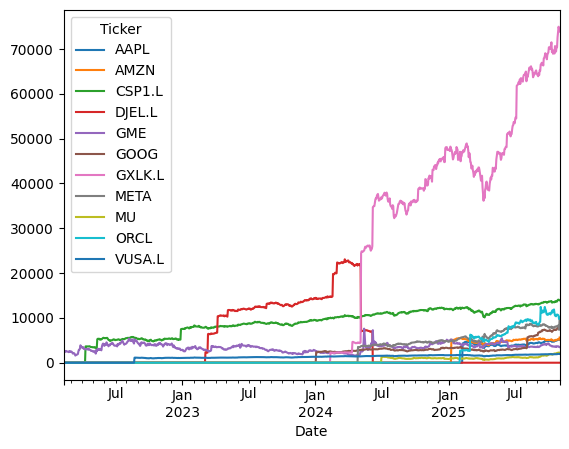

In [7]:
holdings.data.plot()

<Axes: xlabel='Date'>

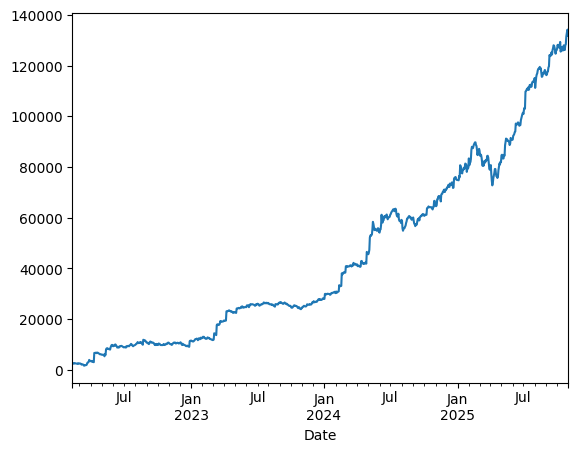

In [8]:
holdings.total.plot()

In [9]:
bmk = Ticker("^SPX").returns

In [27]:
from src.dataclasses.assessment_config import AssessmentConfig


config = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,
    bmk=bmk,
)

In [11]:
from src.assessments.ratios.sharpe_ratio import SharpeRatio

sharpe = SharpeRatio(config)
sharpe.calc()

0.42721102063307503

In [12]:
from src.assessments.ratios.sortino_ratio import SortinoRatio

sortino = SortinoRatio(config)
sortino.calc()

0.5200619285562988

In [13]:
from src.assessments.cagr import CAGR

cagr = CAGR(config)
cagr.calc()

0.22391504197211343

In [14]:
from src.assessments.max_drawdown import MaxDrawdown

max_dd = MaxDrawdown(config)
max_dd.calc()

-0.5098200727365171

In [15]:
from src.assessments.ratios.calmar_ratio import CalmarRatio

calmar = CalmarRatio(config=config)
calmar.calc()

0.43920405246153615

In [16]:
from src.assessments.tracking_error import TrackingError

tracking_error = TrackingError(config)
tracking_error.calc()

0.35766797478389867

In [17]:
from src.assessments.ratios.information_ratio import InformationRatio

information_ratio = InformationRatio(config)
information_ratio.calc()

0.4373411506623918

In [18]:
from src.assessments.beta import Beta

beta = Beta(config)
beta.calc()

0.9227201125219378

In [28]:
from src.evaluation import FullEvaluation

f = FullEvaluation(config).run()
pd.Series(f.results)

Beta                 0.922720
CAGR                 0.223915
Max Drawdown        -0.509820
Tracking Error       0.357668
Sharpe Ratio         0.427211
Information Ratio    0.437341
Calmar Ratio         0.439204
dtype: float64

In [ ]:
# Had more capital and more focused on active mgmt
# (switched away from majority holding in DOW)
config_active = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,  # 3mo US Tresury
    bmk=bmk,  # SP500
    start="2024",
)

f_active = FullEvaluation(config_active).run()
pd.Series(f_active.results)

Beta                 0.732493
CAGR                 0.409848
Max Drawdown        -0.242314
Tracking Error       0.194004
Sharpe Ratio         1.120851
Information Ratio    0.856585
Calmar Ratio         1.691389
dtype: float64